<a href="https://colab.research.google.com/github/nic0l4sB/Machine-Learning/blob/main/ML%20Supervisado%20Reducci%C3%B3n%20de%20dimensionalidad%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -U scikit-learn pandas matplotlib seaborn notebook jupyterlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 149.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 135.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 128.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 131.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 91.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      S

In [ ]:
# Imports y configuración
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris, load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Configuración estética
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8,5)

# Carpeta de salida
OUT = Path("results")
OUT.mkdir(parents=True, exist_ok=True)


In [ ]:
def run_experiment(X, dataset_name, ks=[2,4,5], random_state=42, out_folder=OUT):
    """
    Ejecuta pipeline:
     - estandariza
     - PCA (2 componentes) para visualización
     - KMeans para cada k en ks
     - calcula silhouette score y guarda gráficos y CSV
    Retorna DataFrame con resultados.
    """
    out_folder = Path(out_folder)
    out_folder.mkdir(parents=True, exist_ok=True)
    results = []

    # 1. Estandarizar
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    # 2. PCA (2D) para visualización
    pca = PCA(n_components=2, random_state=random_state)
    Xp = pca.fit_transform(Xs)
    pca_explained = pca.explained_variance_ratio_.sum()

    for k in ks:
        # 3. KMeans
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        labels = kmeans.fit_predict(Xs)

        # 4. Métricas
        sil_score = silhouette_score(Xs, labels)
        sample_sil = silhouette_samples(Xs, labels)

        results.append({
            "dataset": dataset_name,
            "k": k,
            "silhouette": float(sil_score),
            "pca_explained_var": float(pca_explained)
        })

        # 5. Gráfica: PCA con clusters y centroides (guardada)
        fig, ax = plt.subplots()
        scatter = ax.scatter(Xp[:,0], Xp[:,1], c=labels, s=40)
        centers_2d = pca.transform(kmeans.cluster_centers_)
        ax.scatter(centers_2d[:,0], centers_2d[:,1], marker='X', s=150, c='k')
        ax.set_title(f"{dataset_name} — KMeans k={k} — Silhouette={sil_score:.4f}")
        ax.set_xlabel("PCA1")
        ax.set_ylabel("PCA2")
        plt.colorbar(scatter, ax=ax, label="cluster")
        pca_fn = out_folder / f"{dataset_name}_k{k}_pca.png"
        plt.tight_layout()
        plt.savefig(pca_fn, dpi=150)
        plt.close(fig)

        # 6. Gráfica: Silhouette plot (guardada)
        fig, ax = plt.subplots()
        y_lower = 10
        for i in range(k):
            ith_sil_vals = sample_sil[labels == i]
            ith_sil_vals.sort()
            size_i = ith_sil_vals.shape[0]
            y_upper = y_lower + size_i
            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_sil_vals, alpha=0.7)
            ax.text(-0.05, y_lower + 0.5 * size_i, str(i))
            y_lower = y_upper + 10
        ax.set_title(f"Silhouette plot: {dataset_name} k={k} (avg={sil_score:.4f})")
        ax.set_xlabel("Silhouette coefficient")
        ax.set_ylabel("Sample index")
        ax.axvline(x=sil_score, color="red", linestyle="--")
        sil_fn = out_folder / f"{dataset_name}_k{k}_silhouette.png"
        plt.tight_layout()
        plt.savefig(sil_fn, dpi=150)
        plt.close(fig)

    results_df = pd.DataFrame(results).sort_values(['dataset','k']).reset_index(drop=True)
    results_df.to_csv(out_folder / f"{dataset_name}_results.csv", index=False)
    return results_df


In [ ]:
# Cargar datasets
iris = load_iris()
X_iris = iris.data

wine = load_wine()
X_wine = wine.data

# Ejecutar
iris_res = run_experiment(X_iris, "Iris", ks=[2,4,5], random_state=42)
wine_res = run_experiment(X_wine, "Wine", ks=[2,4,5], random_state=42)

# Combinar y guardar
combined = pd.concat([iris_res, wine_res], ignore_index=True)
combined.to_csv(OUT / "results_combined.csv", index=False)

# Mostrar resultado resumen
print("Resultados combinados:")
display(combined)


Resultados combinados:


,dataset,k,silhouette,pca_explained_var
0,Iris,2,0.581750,0.958132
1,Iris,4,0.386941,0.958132
2,Iris,5,0.345901,0.958132
3,Wine,2,0.259317,0.554063
4,Wine,4,0.260170,0.554063
5,Wine,5,0.201619,0.554063


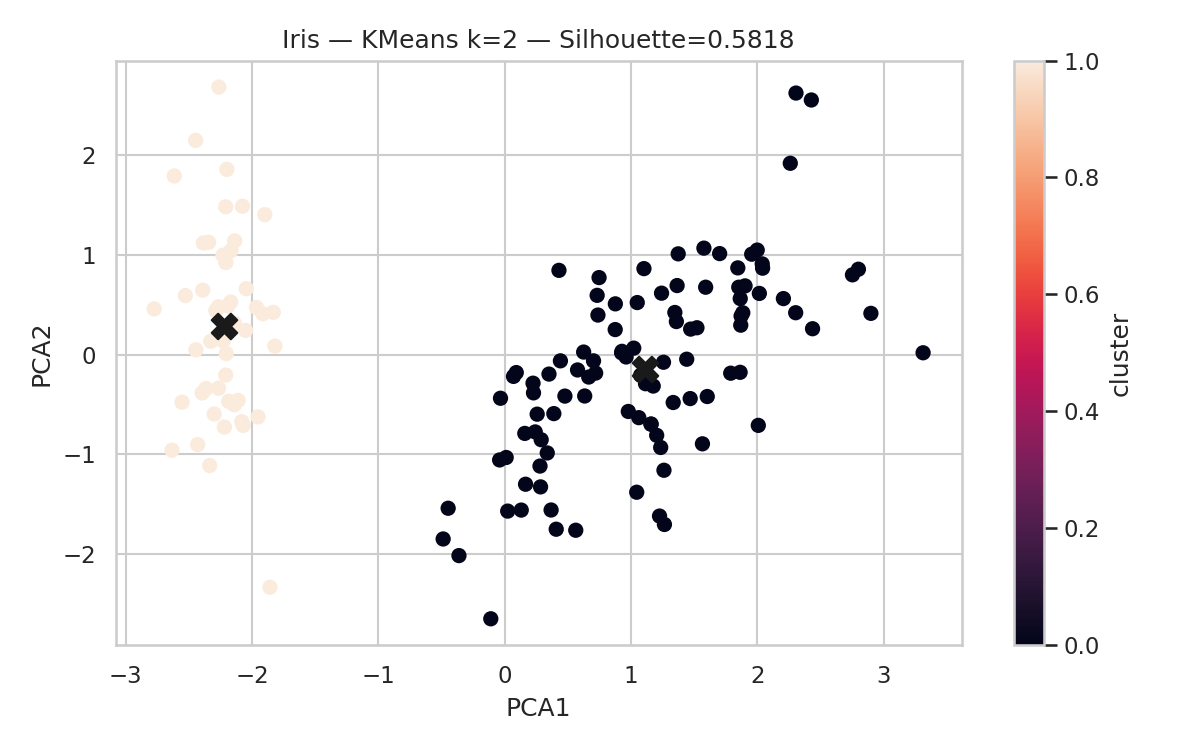

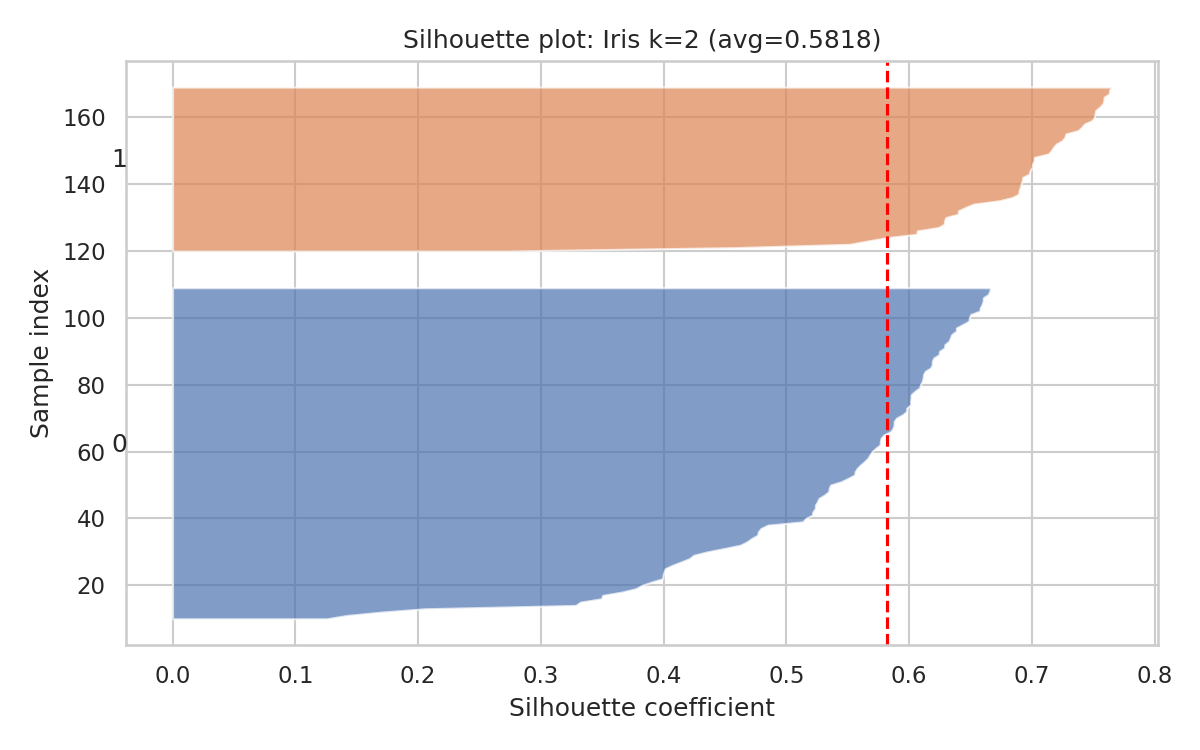

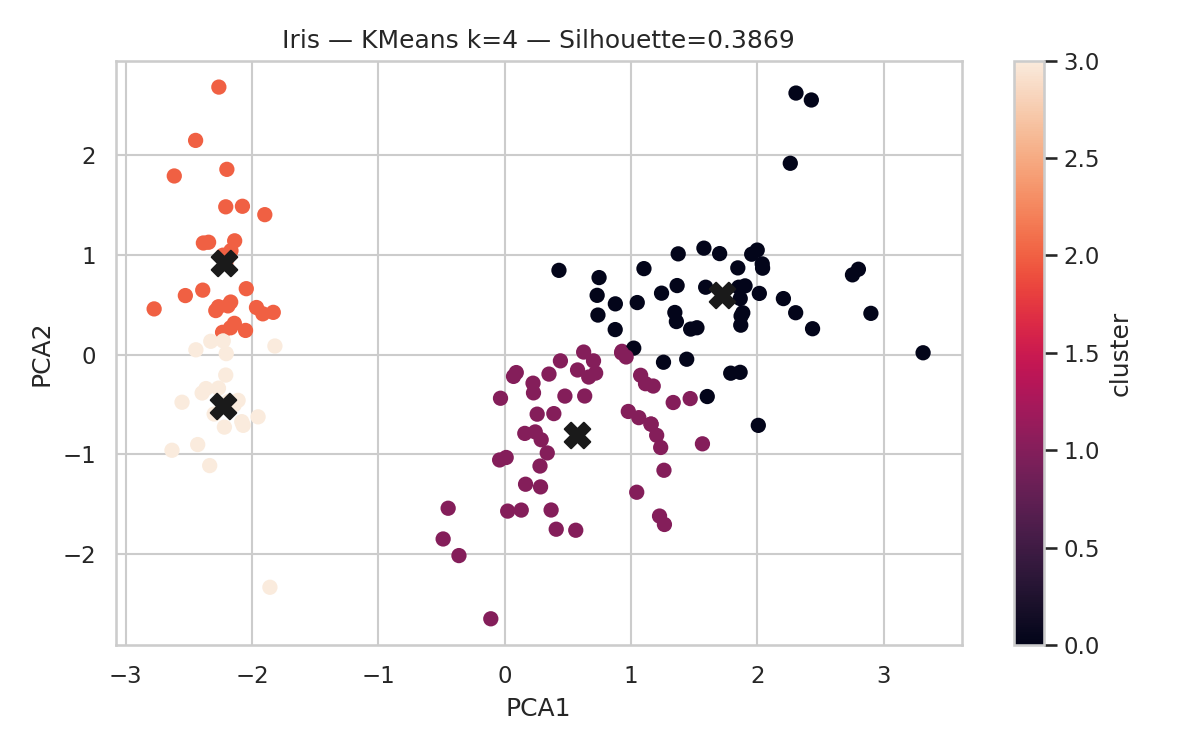

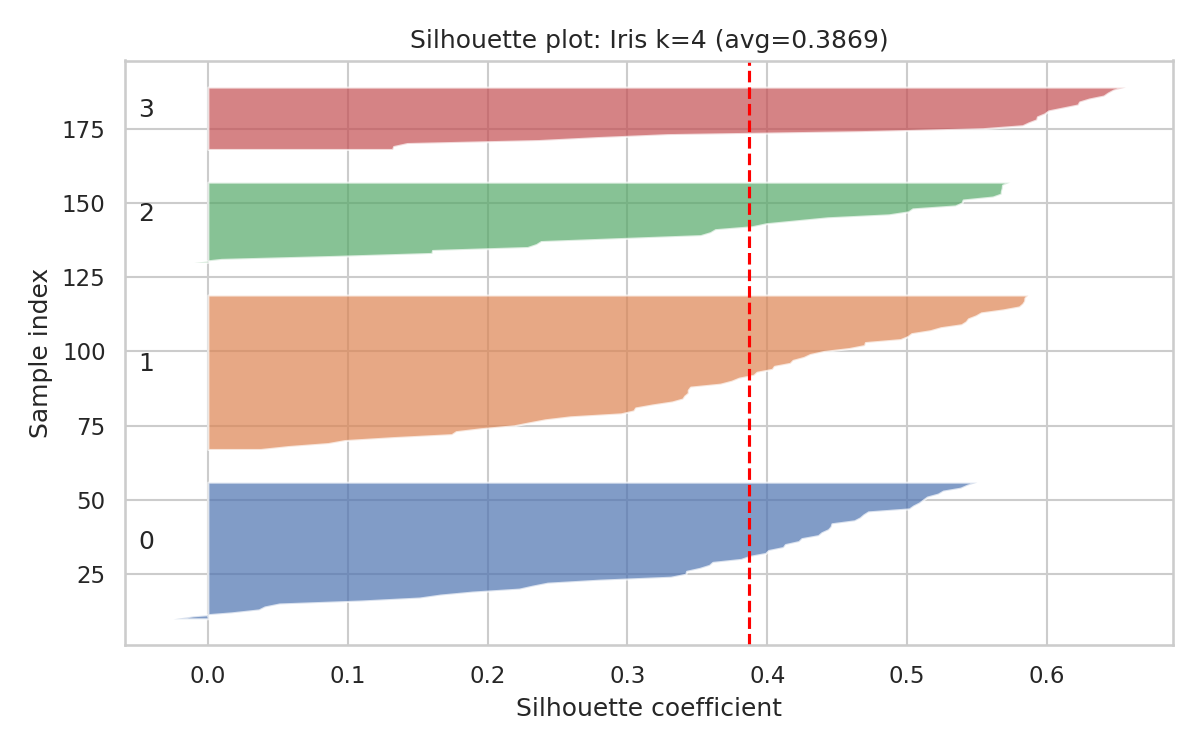

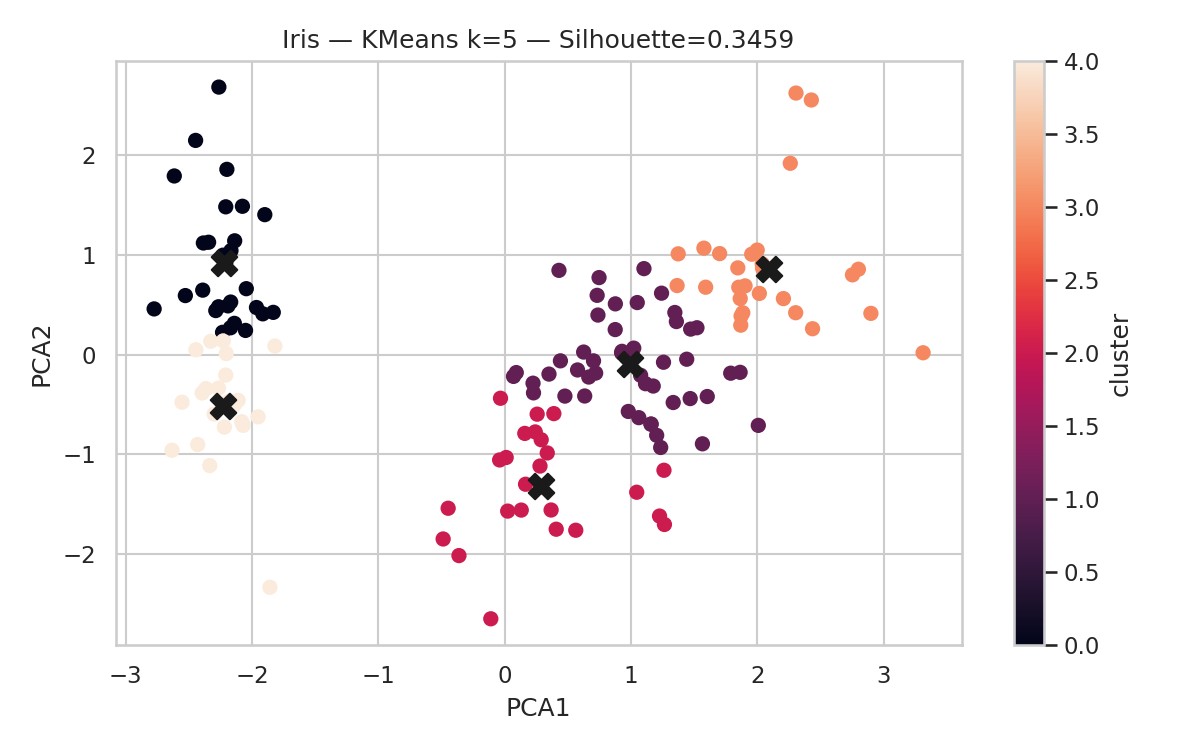

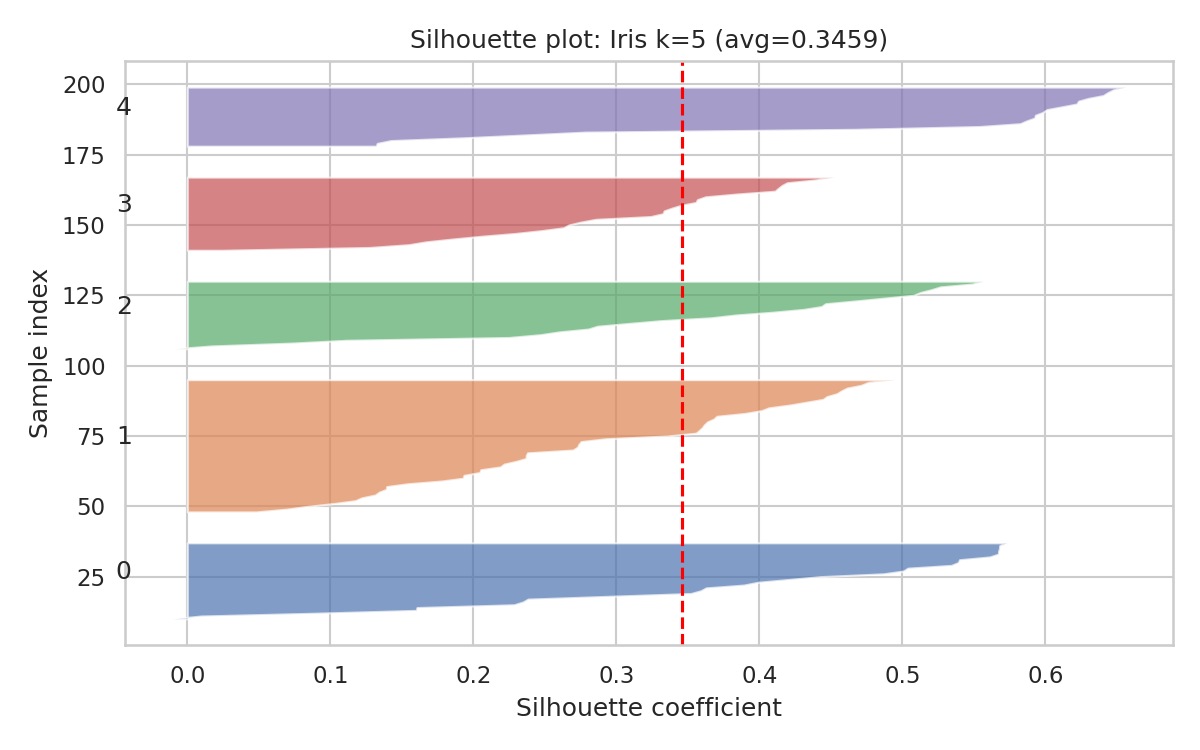

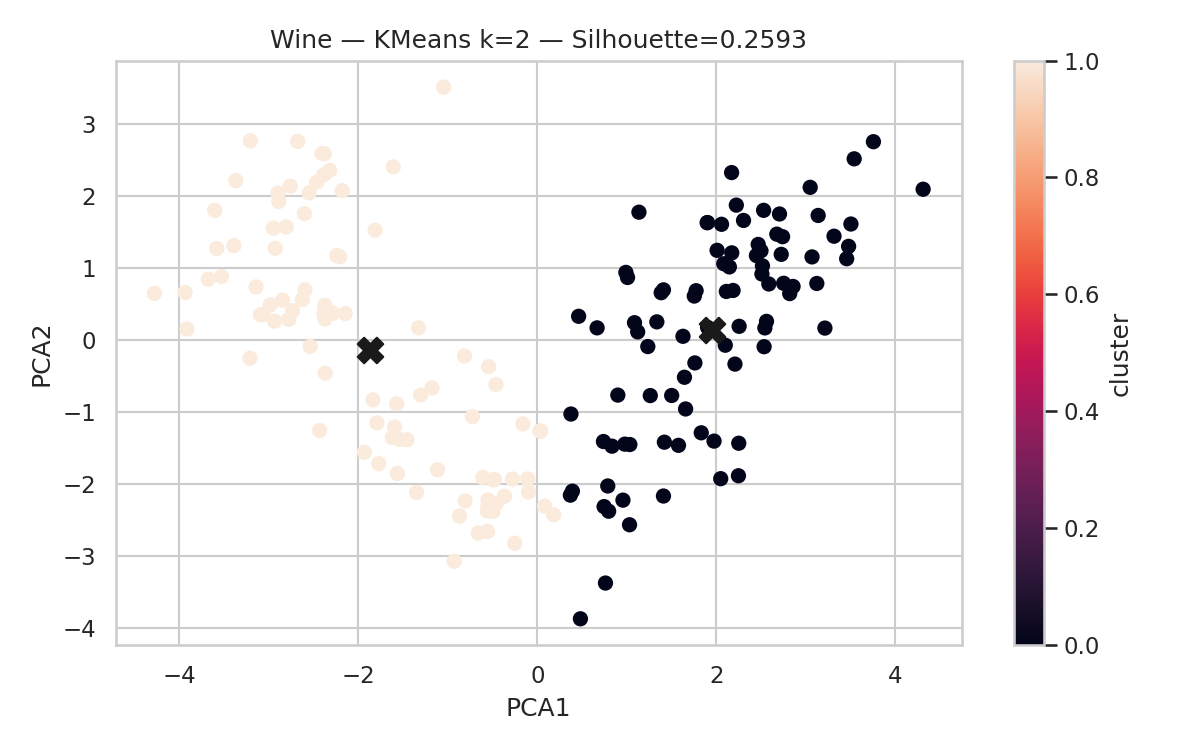

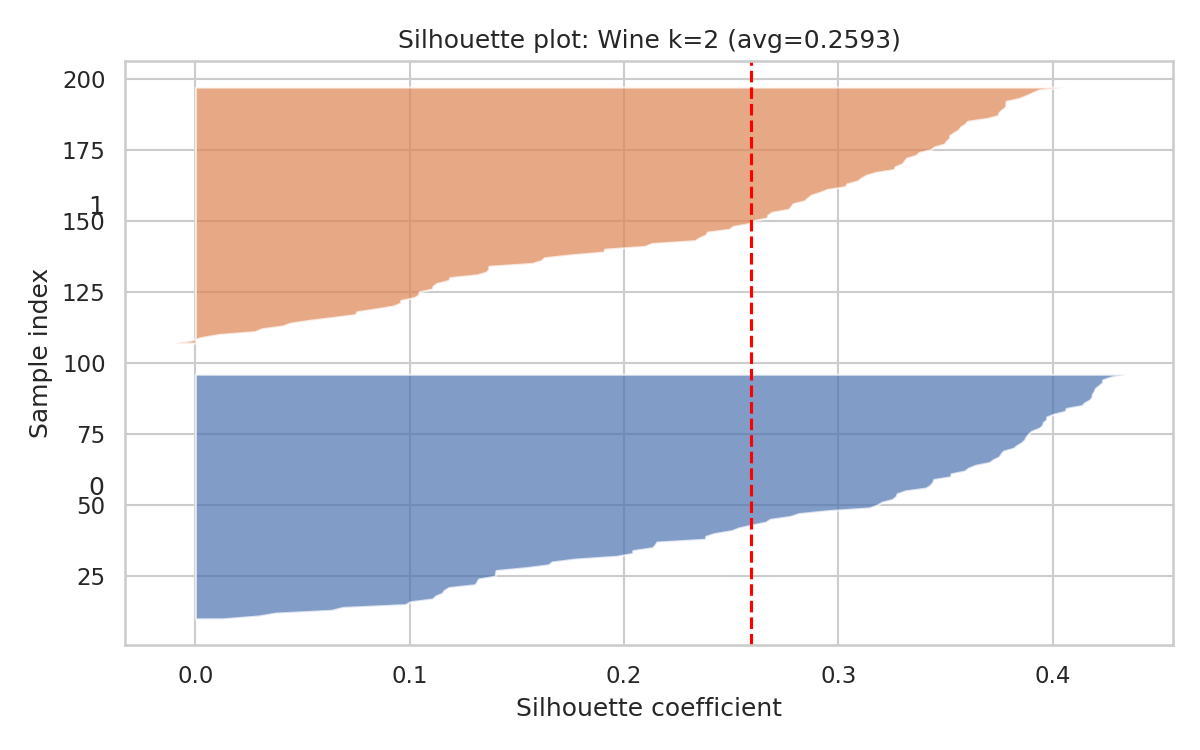

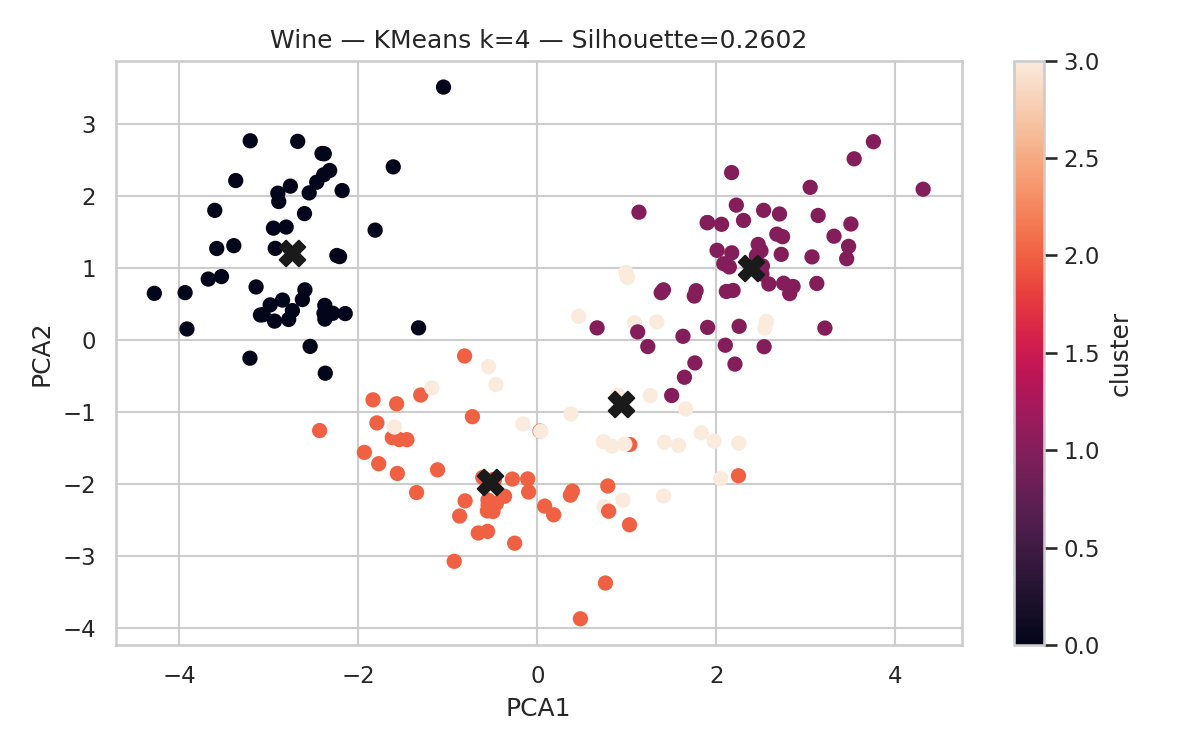

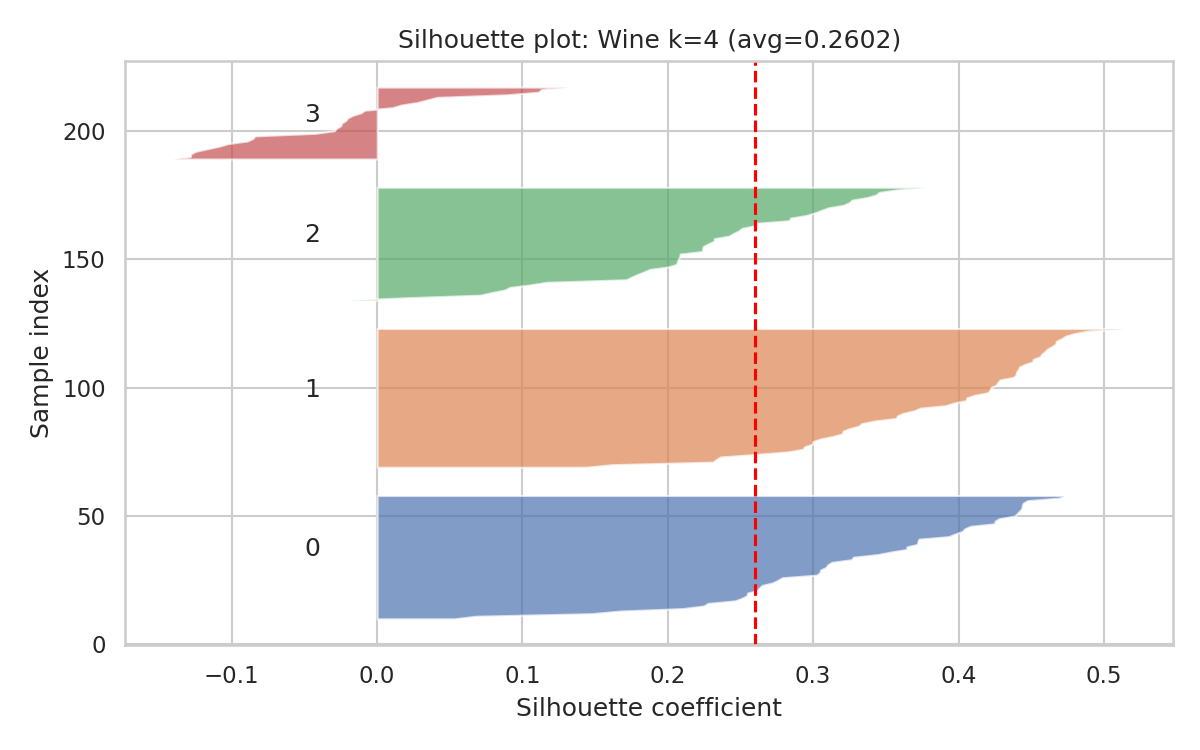

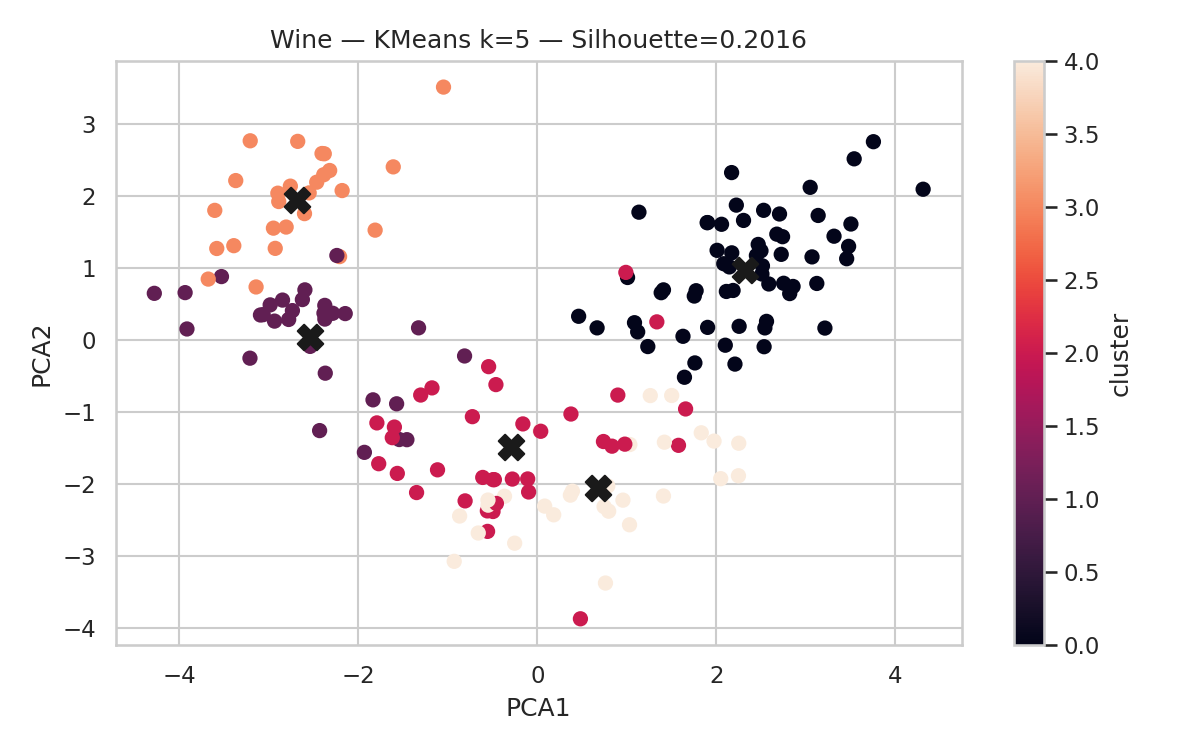

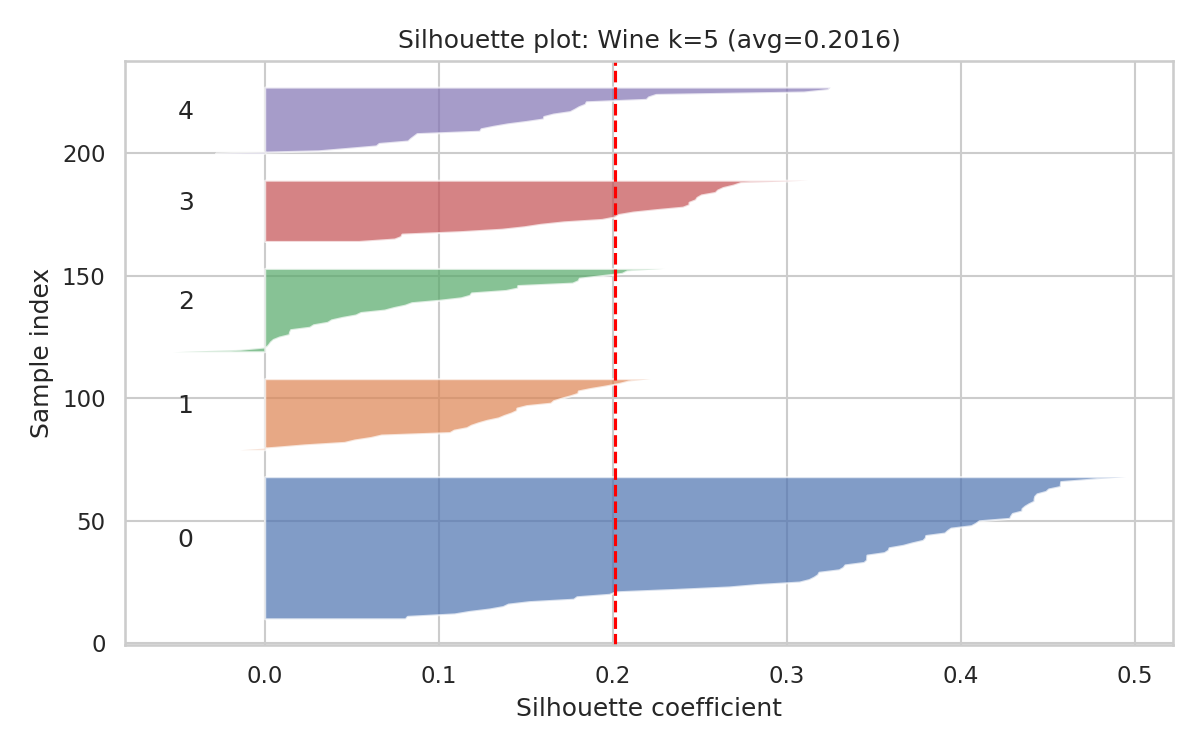

In [ ]:
from IPython.display import Image, display
for dataset in ["Iris","Wine"]:
    for k in [2,4,5]:
        display(Image(filename=OUT / f"{dataset}_k{k}_pca.png"))
        display(Image(filename=OUT / f"{dataset}_k{k}_silhouette.png"))
